# Visión Estéreo para Medición de Distancias

Este proyecto implementa un sistema de visión estéreo para calcular distancias en profundidad, incluyendo calibración de cámaras, rectificación de imágenes y cálculo de disparidad.



## Objetivo

Este proyecto desarrolla un sistema capaz de medir distancias en profundidad utilizando técnicas de visión estéreo, validando el sistema con objetos a distancias conocidas.



## Configuración del Entorno

Se configuran las bibliotecas necesarias para el procesamiento de imágenes estéreo, calibración de cámaras y cálculo de disparidad.



In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data, io, filters, img_as_ubyte
import cv2
import util_visionestereo_challenge as uvc

import warnings
warnings.filterwarnings("ignore")

### Sistema de Visión Estéreo

Se utiliza un sistema de visión estéreo previamente calibrado. Se han obtenido los parámetros intrínsecos para las cámaras izquierda y derecha (`mtx_left`, `mtx_right`), las distorsiones de cada una (`dist_left`, `dist_right`), así como las coordenadas reales del patrón de calibración (`objpoints`) y las coordenadas en las imágenes de calibración (`imgpointsL`, `imgpointsR`). Todos estos valores se encuentran en el archivo `calibrated.npz`.



In [2]:
npzfile = np.load("calibrated.npz")

objpoints = npzfile['objpoints']
imgpointsL = npzfile['imgpointsL']
imgpointsR = npzfile['imgpointsR']
mtx_left = npzfile['mtx_left']
mtx_right = npzfile['mtx_right']
dist_left = npzfile['dist_left']
dist_right = npzfile['dist_right']

### Imágenes de Validación

Se proporcionan dos conjuntos de imágenes de prueba (`test1` y `test2`) con las capturas de las cámaras izquierda y derecha. El sistema se valida comparando las distancias calculadas con valores conocidos: el objeto en `test1` está a 85cm y en `test2` a 105cm. Estas imágenes se encuentran en el directorio `imgs`.



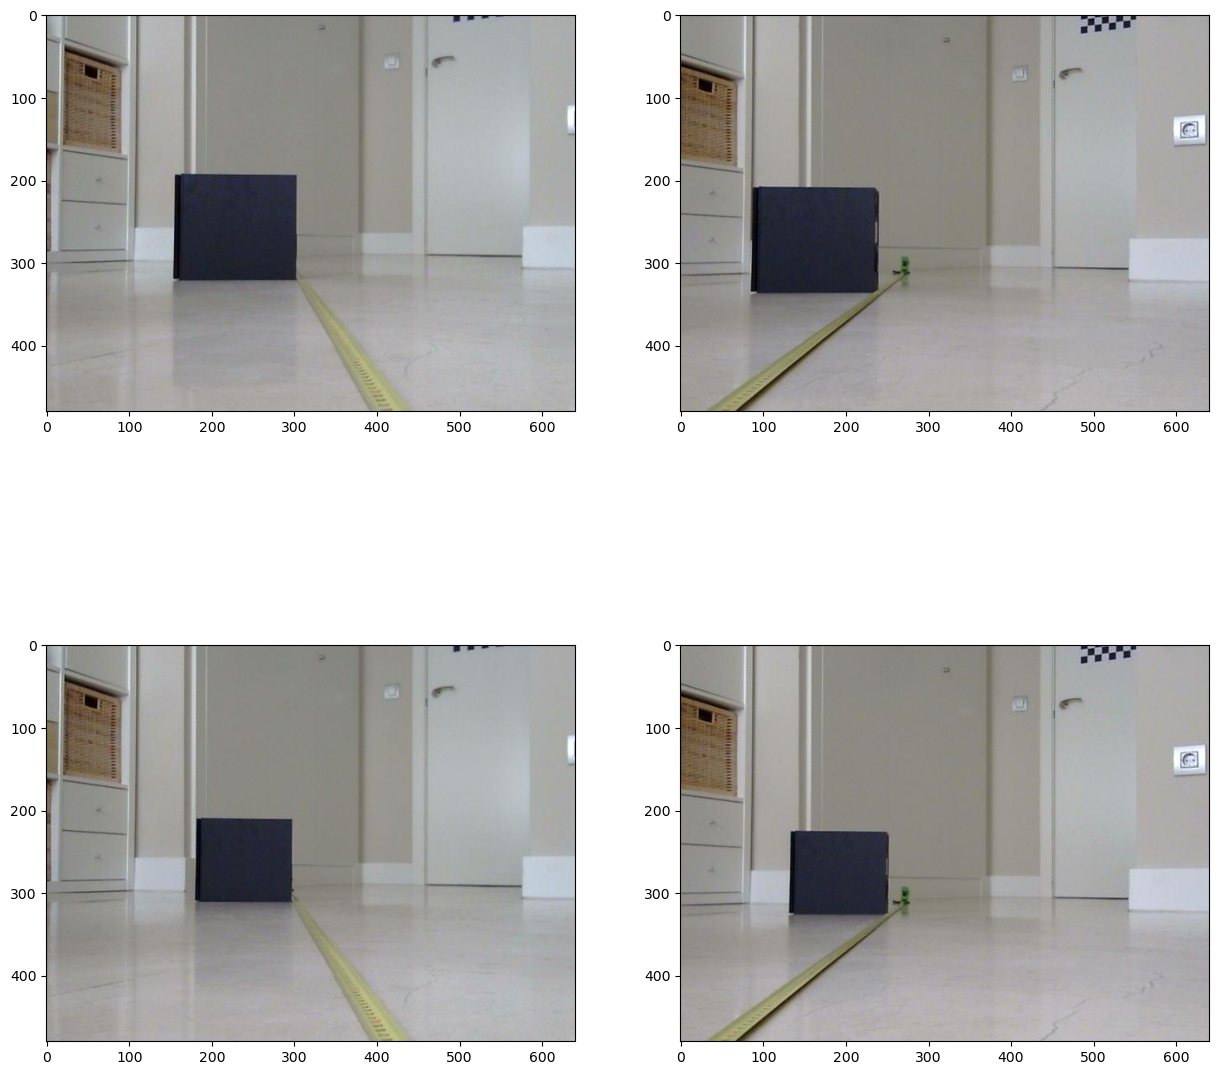

In [3]:
frameL_test1 = io.imread("imgs/img_L_test1.jpg")
frameR_test1 = io.imread("imgs/img_R_test1.jpg")

frameL_test2 = io.imread("imgs/img_L_test2.jpg")
frameR_test2 = io.imread("imgs/img_R_test2.jpg")

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,15))
ax1[0].imshow(frameL_test1)
ax1[1].imshow(frameR_test1)
ax2[0].imshow(frameL_test2)
ax2[1].imshow(frameR_test2)
io.show()


### Calibración estéreo

A partir de los datos que se disponen de las cámaras, obtén las matrices `R` y `T` necesarias para rectificar cada par de imágenes:



In [7]:
# Realizo la calibración estéreo para obtener las matrices de rotación y translación.
gray_frame = cv2.cvtColor(frameL_test1, cv2.COLOR_BGR2GRAY)
img_shape = gray_frame.shape[::-1]

flags = cv2.CALIB_FIX_INTRINSIC
ret, mtx_left, dist_left, mtx_right, dist_right, R, T, E, F = cv2.stereoCalibrate(
    objpoints, imgpointsL, imgpointsR,
    mtx_left, dist_left,
    mtx_right, dist_right,
    img_shape, flags=flags
)

print("He calculado la matriz de Rotación (R):")
print(R)
print("\nHe calculado la matriz de Translación (T):")
print(T)



He calculado la matriz de Rotación (R):
[[ 9.99489602e-01  7.78521995e-04  3.19363248e-02]
 [-7.92494214e-04  9.99999596e-01  4.24846845e-04]
 [-3.19359811e-02 -4.49939357e-04  9.99489815e-01]]

He calculado la matriz de Translación (T):
[[-141.49057548]
 [  -1.94150041]
 [   0.48896003]]


Calcula los mapas de rectificación `Left_Stereo_Map` y `Right_Stereo_Map`, necesarios para rectificar cualquier imagen capturada por las cámaras izquierda y derecha:



In [8]:
# A continuación, calculo los mapas de rectificación que necesitaré más adelante.
R1, R2, P1, P2, Q, roi_left, roi_right = cv2.stereoRectify(
    mtx_left, dist_left,
    mtx_right, dist_right,
    img_shape, R, T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=-1
)

Left_Stereo_Map = cv2.initUndistortRectifyMap(
    mtx_left, dist_left, R1, P1,
    img_shape, cv2.CV_16SC2
)
Right_Stereo_Map = cv2.initUndistortRectifyMap(
    mtx_right, dist_right, R2, P2,
    img_shape, cv2.CV_16SC2
)

Crea una función que a partir de las imágenes izquierda y derecha y los mapas de rectificación, nos devuelva los mapas de disparidad de la imagen izquierda con respecto a la derecha, las imágenes izquierda y derecha rectificadas, así como los valores de disparidad.



In [10]:
def obtenerMapasDeDisparidadYValores (img_left, img_right, Left_Stereo_Map, Right_Stereo_Map):
    
    # Implementa una función que a partir de las imágenes izquierda y derecha y los mapas de rectificación, 
    # nos devuelva los mapas de disparidad de la imagen izquierda con respecto a la derecha, 
    # las imágenes izquierda y derecha rectificadas, así como los valores de disparidad.
   
    # Rectifico las imágenes para alinearlas.
    frameLRec = cv2.remap(img_left, Left_Stereo_Map[0], Left_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    frameRRec = cv2.remap(img_right, Right_Stereo_Map[0], Right_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

    # Convierto a escala de grises las dos imágenes rectificadas.
    grayFrameLRec = cv2.cvtColor(frameLRec, cv2.COLOR_BGR2GRAY)
    grayFrameRRec = cv2.cvtColor(frameRRec, cv2.COLOR_BGR2GRAY)
    
    # Creo el objeto StereoSGBM para el cálculo de disparidad.
    min_disp = 0
    num_disp = 128
    block_size = 5
    uniqueness_ratio = 10
    speckle_window_size = 100
    speckle_range = 32
    disp12_max_diff = 1
    P1 = 8 * 3 * block_size**2
    P2 = 32 * 3 * block_size**2
    
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        P1=P1,
        P2=P2,
        disp12MaxDiff=disp12_max_diff,
        uniquenessRatio=uniqueness_ratio,
        speckleWindowSize=speckle_window_size,
        speckleRange=speckle_range
    )
    
    # Calculo el mapa de disparidad de la imagen izquierda.
    disp = stereo.compute(grayFrameLRec, grayFrameRRec)
    
    # Calculo los valores normalizados de la disparidad.
    disp_values = np.copy (disp)   
    disp_values = disp_values.astype(float)
    disp_values = (disp_values - (min_disp * 16)) / (16.0 * num_disp)
    
    # Normalizo el mapa de disparidad para poder visualizarlo.
    disp_norm = cv2.normalize(disp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Creo un matcher para la imagen derecha para usarlo con el filtro WLS.
    stereoR = cv2.ximgproc.createRightMatcher(stereo)
    
    # Calculo el mapa de disparidad de la imagen derecha.
    dispR = stereoR.compute(grayFrameRRec, grayFrameLRec)
    
    # Creo el objeto para el filtro de disparidad WLS.
    lmbda = 8000
    sigma = 1.2
    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    # Aplico el filtro para mejorar el mapa de disparidad.
    dispFiltered = wls_filter.filter(disp, grayFrameLRec, None, dispR)
    dispFiltered = cv2.normalize(src=dispFiltered, dst=dispFiltered, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # La función devuelve el mapa de disparidad normalizado entre 0 y 255 para visualizar, 
    # el mapa de disparidad mejorado con el filtro WLS, los valores de disparidad, la imagen izquierda en escala
    # de grises y la imagen derecha en escala de grises
    return disp_norm, dispFiltered, disp_values, grayFrameLRec, grayFrameRRec

Se muestran los mapas de disparidad (el normal y el mejorado), así como la imagen de la cámara izquierda rectificada:



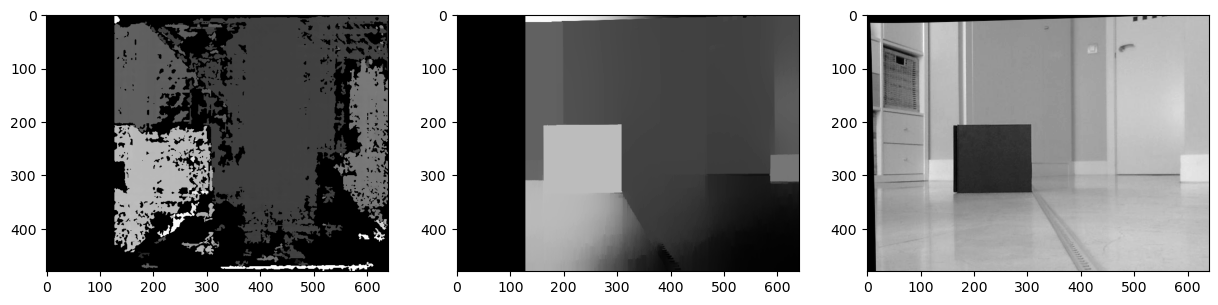

In [11]:
disp_image, disp_image_filtered, disp_values, image_L_rec, image_R_rec = obtenerMapasDeDisparidadYValores (frameL_test1, frameR_test1, Left_Stereo_Map, Right_Stereo_Map)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(disp_image, cmap=plt.cm.gray)
ax2.imshow(disp_image_filtered, cmap=plt.cm.gray)
ax3.imshow(image_L_rec, cmap=plt.cm.gray)
io.show()

A partir de los valores de disparidad `disp_values` y distintas imágenes controladas, se ha creado un modelo que nos devuelve la distancia en función de los valores de disparidad. Puedes comprobar como se ha definido este modelo en el fichero `util_visionestereo_



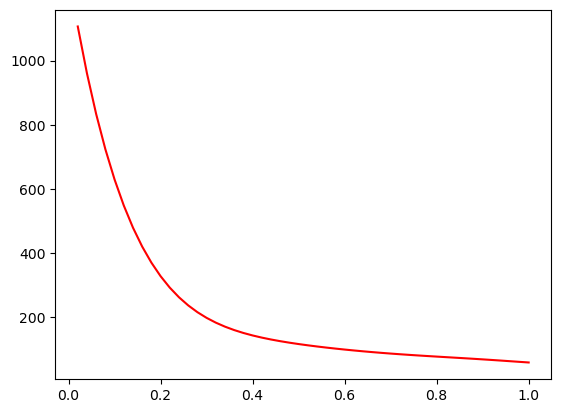

In [12]:
model = uvc.Disparidad2Distancia()
model.plot()

El siguiente problema a resolver sería aislar el objeto que queremos reconocer para obtener sus valores de disparidad. En este caso te recomiendo que utilices las técnicas de binarización sobre la imagen rectificada izquierda y uses el algoritmo de detección de blobs `label` junto con `regionprops` que ya hemos utilizado en otras sesiones.Crea una función que a partir de una imagen, nos retorne el rectángulo de ocupación en píxeles del objeto del que queremos medir su distancia:



In [13]:
from skimage.morphology import dilation
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import disk
from skimage.util import invert
from skimage.filters import threshold_otsu

def obtenerLimitesObjeto (img_gris_rectificada):
    
    # Implementa una función que devuelva un rectángulo con las coordenadas del objeto
    
    # Invierto la imagen para que el objeto (la caja oscura) se vuelva blanco y el fondo negro.
    img_invertida = invert(img_gris_rectificada)
    
    # Binarizo la imagen usando el umbral de Otsu para separar el objeto del fondo.
    thresh_val = threshold_otsu(img_invertida)
    thresh = img_invertida > thresh_val
    
    # Aplico una dilatación para hacer el objeto más sólido y rellenar posibles huecos.
    selem = disk(10)
    img_dilatada = dilation(thresh, selem)
    
    # Etiqueto las diferentes regiones o "blobs" que han quedado en la imagen.
    label_img = label(img_dilatada)
    
    # Calculo las propiedades de cada región para poder analizarlas.
    rois = regionprops(label_img)
    
    
    # Busco la región que más se parece a un rectángulo sólido (la caja).
    for roi in rois:
        if roi.area / roi.bbox_area > 0.85 and roi.bbox_area > 1000:
            return roi.bbox
        
    return (0,0,0,0)

Vamos a comprobar si el resultado es el correcto. Pintemos un rectángulo con las coordenadas obtenidas en la imagen donde hemos buscado el objeto y en el mapa de disparidad:



(196, 152, 347, 320)


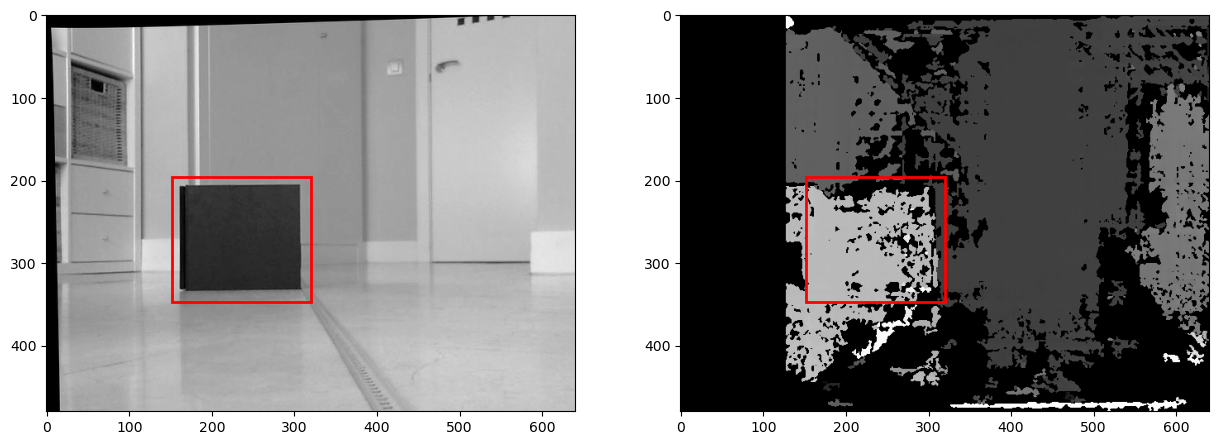

In [14]:
rect_obj = obtenerLimitesObjeto(image_L_rec)

print (rect_obj)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(image_L_rec, cmap=plt.cm.gray)
rect=mpatches.Rectangle((rect_obj[1],rect_obj[0]),rect_obj[3]-rect_obj[1],rect_obj[2]-rect_obj[0], 
                        fill = False,
                        color = "red",
                        linewidth = 2)
ax1.add_patch(rect)
ax2.imshow(disp_image, cmap=plt.cm.gray)
rect=mpatches.Rectangle((rect_obj[1],rect_obj[0]),rect_obj[3]-rect_obj[1],rect_obj[2]-rect_obj[0], 
                        fill = False,
                        color = "red",
                        linewidth = 2)
ax2.add_patch(rect)
io.show()

Veamos un histograma de los valores de las disparidades en esa región:



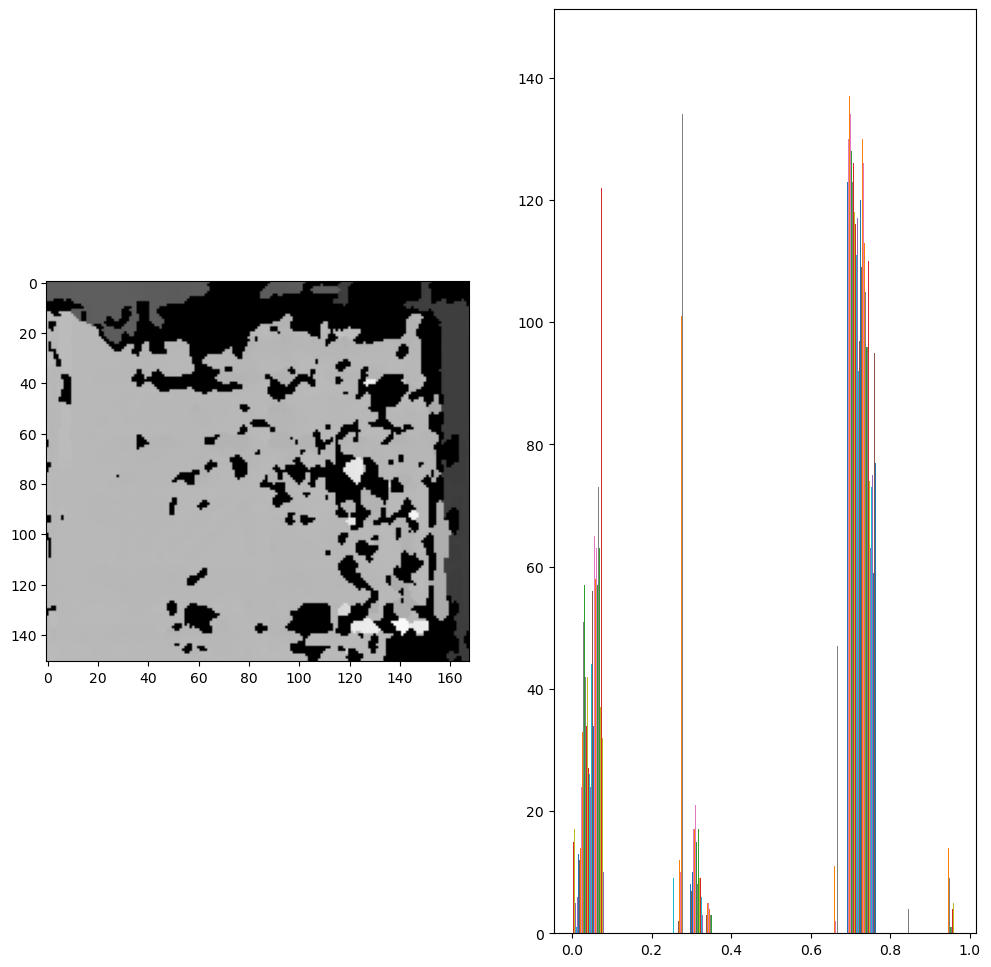

In [15]:
rango = disp_values[rect_obj[0]:rect_obj[2], rect_obj[1]:rect_obj[3]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
ax1.imshow(rango, cmap=plt.cm.gray, vmin=0.0, vmax=1.0)
ax2.hist(rango, bins=10)
io.show()

Implementa una función que nos devuelva un valor de disparidad a partir de una matriz de disparidades. Nos interesaría buscar el valor medio entre los valores más repetidos (observa el histograma):



In [16]:
def obtenerDisparidad (disparidades):

    # Calculo el histograma de las disparidades para encontrar el valor más frecuente.
    hist, bin_edges = np.histogram(disparidades, bins=20)
    
    # Encuentro el índice del bin con la mayor cantidad de valores.
    max_index = np.argmax(hist)
    
    # Tomo el centro de ese bin como el valor de disparidad más representativo.
    disparidad = (bin_edges[max_index] + bin_edges[max_index+1]) / 2.0
    
    return disparidad

El valor de la distancia entre el objeto detectado y las cámaras de visión estéreo sería:



In [17]:
print ("La distancia al objeto es de: ", model.obtenerDistancia(obtenerDisparidad (rango)), "cm")

La distancia al objeto es de:  86.2176979834519 cm


Repite todo el proceso que hemos hecho para las imágenes que corresponden al `test2`, no vuelvas a definir las funciones que hemos construido, utilízalas directamente. Evalua el resultado de la distancia al objeto y comenta los resultados y el proceso que hemos seguido.



La distancia calculada para el objeto en el test2 es de: 106.88 cm


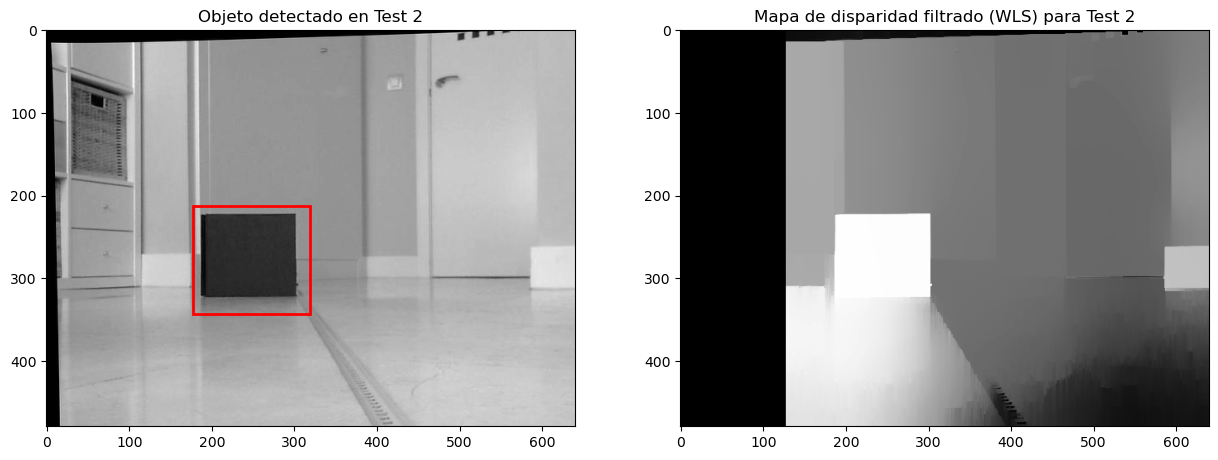

In [18]:
# 1. Aplico el pipeline a las imágenes del test2 para obtener los mapas de disparidad y las imágenes rectificadas.
disp_image_t2, disp_filtered_t2, disp_values_t2, image_L_rec_t2, image_R_rec_t2 = obtenerMapasDeDisparidadYValores(
    frameL_test2, frameR_test2, Left_Stereo_Map, Right_Stereo_Map
)

# 2. Encuentro el objeto en la nueva imagen rectificada.
rect_obj_t2 = obtenerLimitesObjeto(image_L_rec_t2)

# 3. Aíslo los valores de disparidad correspondientes a ese objeto.
rango_t2 = disp_values_t2[rect_obj_t2[0]:rect_obj_t2[2], rect_obj_t2[1]:rect_obj_t2[3]]

# 4. Calculo la disparidad representativa para el objeto en el test2.
disparidad_t2 = obtenerDisparidad(rango_t2)

# 5. Obtengo la distancia final y la imprimo.
distancia_t2 = model.obtenerDistancia(disparidad_t2)
print(f"La distancia calculada para el objeto en el test2 es de: {distancia_t2:.2f} cm")

# Opcional: Visualizo el resultado para comprobar que todo es correcto.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.set_title("Objeto detectado en Test 2")
ax1.imshow(image_L_rec_t2, cmap=plt.cm.gray)
rect=mpatches.Rectangle((rect_obj_t2[1],rect_obj_t2[0]),rect_obj_t2[3]-rect_obj_t2[1],rect_obj_t2[2]-rect_obj_t2[0], 
                        fill=False, color="red", linewidth=2)
ax1.add_patch(rect)

ax2.set_title("Mapa de disparidad filtrado (WLS) para Test 2")
ax2.imshow(disp_filtered_t2, cmap='gray')
io.show()